In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sales-cycle-cohort-data/cohorts.csv


# GET DATA

In [3]:
import pandas as pd

df0 = pd.read_csv('/kaggle/input/sales-cycle-cohort-data/cohorts.csv')

df0.head()

,Unnamed: 0,lead,phase2,phase3,closed
0,3,2015-06-19,2015-07-30,2015-08-11,2015-08-11
1,4,2015-06-20,2015-07-20,2015-07-20,2015-07-20
2,5,2015-06-21,NaN,NaN,NaN
3,6,2015-06-22,2015-06-30,2015-07-13,2015-07-13
4,7,2015-06-23,NaN,NaN,NaN


# PREPROCESSING DATA

**Named the unnamed column**

Will use as identifier object.

In [4]:
df1 = df0.copy() 

df1.columns.values[0] = 'ID'
df1.head()

,ID,lead,phase2,phase3,closed
0,3,2015-06-19,2015-07-30,2015-08-11,2015-08-11
1,4,2015-06-20,2015-07-20,2015-07-20,2015-07-20
2,5,2015-06-21,NaN,NaN,NaN
3,6,2015-06-22,2015-06-30,2015-07-13,2015-07-13
4,7,2015-06-23,NaN,NaN,NaN


In [5]:
df1.dtypes

ID         int64
lead      object
phase2    object
phase3    object
closed    object
dtype: object

**Unpivot data**

Im using this method to ease my data processing. I will also use this unpivot data on a data visualization dashboard.

In [6]:
df2 = df1.copy()

In [7]:
df2 = pd.melt(df1, 
            id_vars= 'ID', 
            value_vars= ['lead', 'phase2', 'phase3', 'closed'], 
            var_name= 'Type', 
            value_name='Date')

In [8]:
# df2.to_csv('data.csv', index = False)

In [9]:
df2.head()

,ID,Type,Date
0,3,lead,2015-06-19
1,4,lead,2015-06-20
2,5,lead,2015-06-21
3,6,lead,2015-06-22
4,7,lead,2015-06-23


In [10]:
#Check if theres NA

df2.isna().sum().sum()

14402

In [11]:
df3 = df2.dropna()

In [12]:
#Just check again

df3.isna().values.any()

False

In [13]:
df3.dtypes

ID       int64
Type    object
Date    object
dtype: object

In [18]:
#Reformat date to YYYYMM

from datetime import datetime

df3.loc[:, 'Date'] = pd.to_datetime(df3['Date'])

df3.loc[:, 'cohort'] = df3['Date'].dt.strftime('%Y%m').astype(int)

In [21]:
df_first = df3.groupby('ID')['cohort'].min().reset_index() #take the earliest invoice date

df_first.columns = ['ID', 'first_cohort']

# Merge

df4 = df3.merge(df_first, on = 'ID')

df4

,ID,Type,Date,cohort,first_cohort
0,3,lead,2015-06-19,201506,201506
1,4,lead,2015-06-20,201506,201506
2,5,lead,2015-06-21,201506,201506
3,6,lead,2015-06-22,201506,201506
4,7,lead,2015-06-23,201506,201506
...,...,...,...,...,...
26725,12776,closed,2016-06-14,201606,201604
26726,12780,closed,2016-05-26,201605,201605
26727,12785,closed,2016-06-06,201606,201605
26728,12787,closed,2016-06-08,201606,201605


# PROCESSING DATA

In [23]:
# Count distance

df4['cohort_distance'] = df4['cohort'] - df4['first_cohort']

# **VISUALIZATION**

In [24]:
# Create Headers (1-12)

hd = df4['cohort'].value_counts().reset_index()

hd.columns = ['cohort', 'count']

hd = hd.sort_values(['cohort'])['cohort'].to_list()

hd

[201506,
 201507,
 201508,
 201509,
 201510,
 201511,
 201512,
 201601,
 201602,
 201603,
 201604,
 201605,
 201606]

In [25]:
df4['cohort_distance'] = df4.apply(lambda row: (hd.index(row['cohort']) - hd.index(row['first_cohort'])) if (row['first_cohort'] != 0 and row['cohort'] != 0) else np.nan, axis=1)

In [26]:
# Pivot the data to count transactions made by CustomerID for each cohort and cohort distance
cohort_table = df4.pivot_table(index='first_cohort', columns='cohort_distance', values='ID', aggfunc='count')

# Display the cohort table
print(cohort_table)

cohort_distance       0      1      2      3     4
first_cohort                                      
201506            220.0  149.0  195.0   64.0   4.0
201507            546.0  417.0  428.0   91.0   1.0
201508            671.0  449.0  515.0  113.0   9.0
201509            803.0  583.0  553.0  160.0   8.0
201510            863.0  566.0  648.0  169.0   8.0
201511            823.0  596.0  575.0  139.0   7.0
201512            814.0  644.0  522.0  126.0   6.0
201601           1262.0  799.0  830.0  276.0  24.0
201602           1145.0  785.0  809.0  291.0  18.0
201603           1266.0  791.0  840.0  220.0   NaN
201604           1248.0  890.0  494.0    NaN   NaN
201605           1313.0  351.0    NaN    NaN   NaN
201606            593.0    NaN    NaN    NaN   NaN


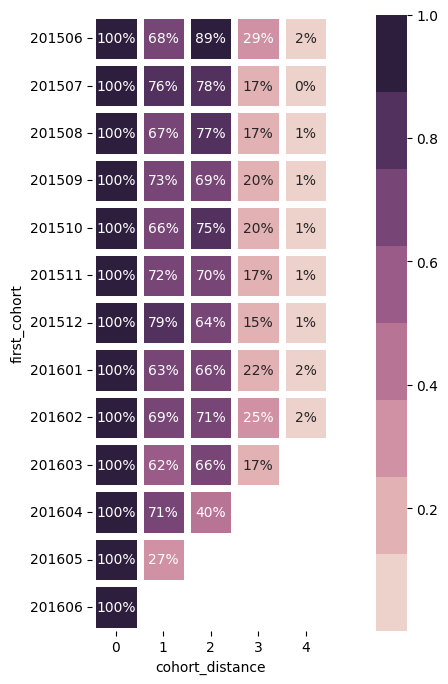

In [29]:
# Normalization
cohort_pivot = cohort_table.div(cohort_table[0], axis=0)

import seaborn as sns
import matplotlib.pyplot as plt

fig_dims = (12,8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(cohort_pivot, annot=True, fmt='.0%', mask=cohort_pivot.isnull(), ax=ax, square=True, linewidth=5, cmap=sns.cubehelix_palette(8))

plt.savefig('cohort.jpg', format='jpg', dpi=300)

plt.show()